100it [00:02, 37.12it/s]
/var/folders/38/3vzxy55538v2l9xwy49ftsb00000gn/T/ipykernel_29557/2093468384.py:133: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  seasonal_index = pivot_with_month.groupby(pivot_with_month.columns.month, axis=1).mean()
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


📌 Validation Evaluation
RMSE : 3,315,679.345
MAE  : 1,237,313.079
R²   : 0.9233
MAPE : 1055160.91%


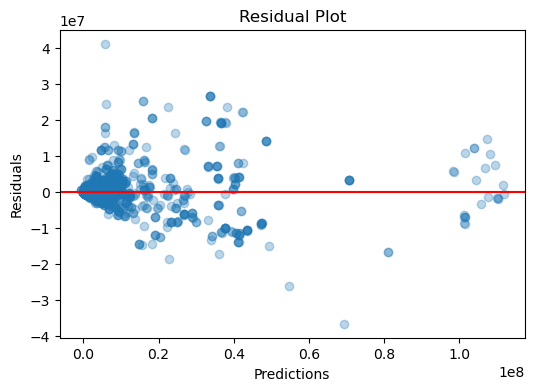

0it [00:00, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# -------------------------
# 1. 데이터 로드 및 전처리 (피벗)
# -------------------------
# 설명: 원본 데이터를 불러와서 모델링하기 좋게 '행: 아이템, 열: 월(Month)' 형태의 행렬로 변환합니다.
train = pd.read_csv('dataset/train.csv')

# 월별 합계 집계 (같은 달에 여러 거래가 있을 수 있으므로 합침)
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# 'YYYY-MM' 형태의 날짜 컬럼 생성 (정렬 및 시계열 처리를 위함)
# zfill(2)는 월이 한 자리수일 때 앞에 0을 붙여줍니다 (예: 1 -> 01)
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

# 피벗 테이블 생성: 행=item_id, 열=ym, 값=value
# fillna(0.0): 거래 내역이 없는 달은 거래량이 0인 것으로 간주
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)


# -------------------------
# 2. 상관계수 계산 함수 (예외 처리 포함)
# -------------------------
# 설명: 데이터의 표준편차가 0일 경우(값이 모두 동일) 상관계수 계산 시 NaN이 발생하는 것을 방지합니다.
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0  # 변동이 없으면 상관관계 없음(0)으로 처리
    return float(np.corrcoef(x, y)[0, 1])


# -------------------------
# 3. 공행성(Co-movement) 쌍 탐색
# -------------------------
# 설명: 선행(Leader) 상품이 변했을 때, 일정 시간(Lag) 뒤에 따라 움직이는 후행(Follower) 상품을 찾습니다.
def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)
    results = []

    # 모든 아이템을 Leader 후보로 순회
    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float) # Leader의 시계열 데이터
        
        # 데이터가 너무 희소하면(0이 아닌 값이 적으면) 분석에서 제외
        if np.count_nonzero(x) < min_nonzero:
            continue

        # 모든 아이템을 Follower 후보로 순회
        for follower in items:
            if follower == leader: # 자기 자신은 제외
                continue
                
            y = pivot.loc[follower].values.astype(float) # Follower의 시계열 데이터
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            # 1개월부터 max_lag개월까지 시차를 두며 상관계수 확인
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                
                # Leader(x)는 앞부분을, Follower(y)는 뒷부분을 잘라서 비교
                # 즉, Leader의 과거 데이터와 Follower의 현재 데이터를 매칭
                corr = safe_corr(x[:-lag], y[lag:])
                
                # 절댓값이 가장 큰(가장 강력한) 상관관계를 찾음
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 상관계수가 설정한 임계값(0.4) 이상인 경우에만 유효한 쌍으로 등록
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    return pd.DataFrame(results)

# 함수 실행하여 쌍 추출
pairs = find_comovement_pairs(pivot)


# -------------------------
# 4. 월별 계절성(Seasonality) 지수 계산
# -------------------------
# 설명: 각 아이템별로 특정 월(1~12월)의 평균 거래량을 계산해 둡니다.
# 이를 통해 "이 아이템은 보통 12월에 잘 팔린다" 같은 패턴을 모델에 반영합니다.
monthly['month_str'] = monthly['month'].astype(str)
seasonal_table = (
    monthly.groupby(['item_id', 'month'])['value']
    .mean()
    .unstack(fill_value=0)
)


# -------------------------
# 5. Feature Engineering (학습 데이터셋 구축)
# -------------------------
# 설명: 찾아낸 쌍 정보를 바탕으로, 회귀분석 모델이 학습할 수 있는 X(특성), y(타겟) 데이터를 만듭니다.
def build_training_data_fe(pivot, pairs):
    months = pivot.columns.to_list()
    n_months = len(months)
    
    # 월 정보 추출을 위해 컬럼을 datetime으로 변환
    pivot_with_month = pivot.copy()
    pivot_with_month.columns = pd.to_datetime(pivot_with_month.columns)
    
    # 전체 월별 평균 테이블 미리 계산 (결측치 대체용)
    seasonal_index = pivot_with_month.groupby(pivot_with_month.columns.month, axis=1).mean()

    rows = []
    
    # 추출된 각 쌍(Pair)에 대해 시계열 데이터를 슬라이딩하며 학습 데이터 생성
    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        
        a_series = pivot.loc[leader].values.astype(float)   # Leader 데이터
        b_series = pivot.loc[follower].values.astype(float) # Follower 데이터
        
        # Follower에 대한 이동 평균 등 파생변수 생성을 위한 임시 DF
        b_df = pd.DataFrame({"b": b_series})

        # [파생변수 1] 이동 평균 (Rolling Mean): 최근 3, 5, 7, 12개월 평균
        b_df["roll_mean_3"] = b_df["b"].rolling(3).mean()
        b_df["roll_mean_5"] = b_df["b"].rolling(5).mean()
        b_df["roll_mean_7"] = b_df["b"].rolling(7).mean()
        b_df["roll_mean_12"] = b_df["b"].rolling(12).mean()
        
        # [파생변수 2] 이동 표준편차 (Rolling Std): 변동성 측정
        b_df["roll_std_3"] = b_df["b"].rolling(3).std()
        b_df["roll_std_5"] = b_df["b"].rolling(5).std()
        b_df["roll_std_12"] = b_df["b"].rolling(12).std()
        
        # [파생변수 3] 추세 (Trend): 전월 대비 증감량
        b_df["trend"] = b_df["b"] - b_df["b"].shift(1)
        
        # [파생변수 4] 계절성 (Seasonality): 해당 월의 평균값 매핑
        b_df["month"] = pivot_with_month.columns.month
        b_df["season_index"] = b_df["month"].apply(
            lambda m: seasonal_index.loc[follower, m] if follower in seasonal_index.index else 0
        )
        
        # 시계열 데이터를 순회하며 (t 시점) -> (t+1 시점 예측) 데이터 생성
        # lag와 rolling window(최대 12)를 고려하여 데이터가 충분한 시점부터 시작
        for t in range(max(lag, 12), n_months - 1):
            b_t = b_series[t]           # Follower의 현재값
            b_t_1 = b_series[t - 1]     # Follower의 전월값
            a_t_lag = a_series[t - lag] # Leader의 lag개월 전 값 (핵심 Feature)
            target = b_series[t + 1]    # 예측 목표: Follower의 다음 달 값
            
            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,       # 상관계수도 feature로 사용 (신뢰도 반영)
                "best_lag": float(lag), # lag 기간도 feature로 사용

                # 미리 계산한 이동평균/표준편차 값 매핑
                "roll_mean_3": b_df.loc[t, "roll_mean_3"],
                "roll_mean_5": b_df.loc[t, "roll_mean_5"],
                "roll_mean_7": b_df.loc[t, "roll_mean_7"],
                "roll_mean_12": b_df.loc[t, "roll_mean_12"],
                
                "roll_std_3": b_df.loc[t, "roll_std_3"],
                "roll_std_5": b_df.loc[t, "roll_std_5"],
                "roll_std_12": b_df.loc[t, "roll_std_12"],

                "trend": b_df.loc[t, "trend"],
                "season_index": b_df.loc[t, "season_index"],
                
                "target": target, # 정답지
            })

    # NaN이 포함된 행 제거 후 반환
    df = pd.DataFrame(rows).dropna()
    return df


# -------------------------
# 6. 모델 학습 (Linear Regression + Scaling)
# -------------------------
df_train_fe = build_training_data_fe(pivot, pairs)

# 학습에 사용할 Feature 목록 정의
feature_cols = [
    'b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag',
    'roll_mean_3','roll_mean_5','roll_mean_7','roll_mean_12',
    'roll_std_3','roll_std_5','roll_std_12',
    'trend','season_index'
]

X = df_train_fe[feature_cols]
y = df_train_fe["target"]

# 학습셋과 검증셋 분리 (검증셋 비율 8.5%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.085, random_state=42
)

# ===== Feature Scaling (중요) =====
# 선형 회귀는 값의 범위(Scale)에 민감하므로 표준화(Standardization) 진행
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # 학습 데이터로 스케일러 학습 및 변환
X_val_scaled = scaler.transform(X_val)         # 검증 데이터는 학습 데이터 기준에 맞춰 변환

# 모델 생성 및 학습
model = LinearRegression()
model.fit(X_train_scaled, y_train)


# -------------------------
# 7. 모델 평가 및 시각화
# -------------------------
def evaluate_model(model, X_val, y_val):
    pred = model.predict(X_val)

    # 평가 지표 계산
    rmse = mean_squared_error(y_val, pred, squared=False)
    mae = mean_absolute_error(y_val, pred)
    r2 = r2_score(y_val, pred)
    # MAPE: 평균 절대 비율 오차 (분모가 0이 되는 것을 방지하기 위해 max(y_val, 1) 사용)
    mape = np.mean(np.abs((y_val - pred) / np.maximum(y_val, 1))) * 100
    
    print("📌 Validation Evaluation")
    print(f"RMSE : {rmse:,.3f}")
    print(f"MAE  : {mae:,.3f}")
    print(f"R²   : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")

    # 잔차(Residual) 플롯 시각화: 예측값과 실제값의 차이 분포 확인
    plt.figure(figsize=(6,4))
    plt.scatter(pred, y_val - pred, alpha=0.3)
    plt.axhline(0, color='red')
    plt.title("Residual Plot")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.show()

evaluate_model(model, X_val_scaled, y_val)


# -------------------------
# 8. 최종 예측 (Future Prediction)
# -------------------------
def predict(pivot, pairs, model, scaler):
    months = pivot.columns.to_list()
    n_months = len(months)
    t_last = n_months - 1 # 데이터의 가장 마지막 시점 (현재)
    t_prev = n_months - 2 # 그 바로 전 시점
    preds = []

    # 각 쌍에 대해 미래(다음 달) 값 예측
    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        # 아이템이 pivot에 없으면 건너뜀 (안전장치)
        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # 예측에 필요한 Leader의 과거 데이터가 존재하는지 확인
        if t_last - lag < 0:
            continue

        # 이동평균 및 표준편차 계산 (최근 데이터 기준)
        b_ts = pd.Series(b_series)
        b_ma3 = b_ts.rolling(3).mean().values
        b_ma5 = b_ts.rolling(5).mean().values
        b_ma7 = b_ts.rolling(7).mean().values
        b_ma12 = b_ts.rolling(12).mean().values
        b_std3 = b_ts.rolling(3).std().values
        b_std5 = b_ts.rolling(5).std().values
        b_std12 = b_ts.rolling(12).std().values

        # Feature 추출
        b_t = b_series[t_last]           # 현재 Follower 값
        b_t_1 = b_series[t_prev]         # 전월 Follower 값
        a_t_lag = a_series[t_last - lag] # Lag만큼 전의 Leader 값 (핵심)

        last_trend = b_t - b_t_1 # 최근 추세
        month_idx = months[t_last].month # 현재 월
        seasonal_idx = seasonal_table.loc[follower, month_idx] # 계절성 지수

        # 모델 입력 벡터 생성 (1, N features) 형태
        X_test = np.array([[
            b_t, b_t_1, a_t_lag, corr, float(lag),
            b_ma3[t_last], b_ma5[t_last], b_ma7[t_last], b_ma12[t_last],
            b_std3[t_last], b_std5[t_last], b_std12[t_last],
            last_trend, seasonal_idx
        ]])

        # ★ 중요: 학습 때와 동일한 Scaler로 변환해야 함
        X_test_scaled = scaler.transform(X_test)
        
        # 예측 수행
        y_pred = model.predict(X_test_scaled)[0]
        
        # 후처리: 음수 예측 방지 및 정수 반올림
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred
        })

    return pd.DataFrame(preds)

# 예측 실행 및 CSV 저장
submission = predict(pivot, pairs, model, scaler)
submission.to_csv('mu_11_25_3rd.csv', index=False)